How different feature extraction methods affect the effectiveness of classification?

In [ ]:
import os
from pathlib import Path
from math import pi
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.applications import VGG16, InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input


In [10]:
train_dir = Path('./data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('./data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('./data/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

aug_dir = Path('./data/augmented/')
aug_filepaths = list(aug_dir.glob(r'**/*.jpg')) + list(aug_dir.glob(r'**/*.jpeg'))

data = train_filepaths + test_filepaths + val_filepaths

In [11]:
def paths_to_dataframe(path):
    labels = []
    for i in range(len(path)):
        labels.append(str(path[i]).split(os.sep)[-2])

    labels = pd.Series(labels, name='Label')
    path = pd.Series(path, name='Path').astype(str)

    df = pd.concat([path, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)

    return df
    
data_df = paths_to_dataframe(data)

In [12]:
data_df = data_df.sample(frac=1, random_state=42)
data_df.shape

(3450, 2)

In [13]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X = np.array(data_df['Path'])
y = np.array(data_df['Label'])

In [14]:
def metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    classification_rep = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(classification_rep)

    classes = np.unique(y_test)
    class_accuracy = {}
    for cls in classes:
        indices = np.where(y_test == cls)[0]
        class_accuracy[cls] = accuracy_score(y_test[indices], np.array(y_pred)[indices])

    return accuracy, precision, recall, f1, class_accuracy

In [15]:
def sort_classes_by_gini_index(X_train, y_train):
    unique_labels = np.unique(y_train)
    gini_indices_per_class = {label: 0 for label in unique_labels}

    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)

    feature_importances = tree.feature_importances_
    sorted_features = np.argsort(feature_importances)[::-1]  # Sort descending by feature importances

    for label in unique_labels:
        indices = np.where(y_train == label)[0]
        gini_indices_per_class[label] = np.mean(feature_importances[sorted_features[:len(indices)]]) if len(indices) > 0 else 0

    sorted_labels = sorted(unique_labels, key=lambda label: gini_indices_per_class[label], reverse=True)
    return sorted_labels

In [16]:
def nested_dichotomy(X_train, y_train, X_test):
    unique_labels = sort_classes_by_gini_index(X_train, y_train)
    classifiers = []

    for i in unique_labels:
        y_binary = np.where(y_train == i, 1, 0)
        tree = DecisionTreeClassifier()
        tree.fit(X_train, y_binary)
        classifiers.append((tree, i))
        print(i)

    predictions = []
    for tree, positive_label in classifiers:
        binary_prediction = tree.predict(X_test)
        predictions.append(np.where(binary_prediction == 1, positive_label, None))

    results = [None for _ in range(len(X_test))]
    for i in range(len(predictions)):
        for j in range(len(X_test)):
            if predictions[i][j] is not None and results[j] == None:
                results[j] = unique_labels[i]

    for i in range(len(results)):
        if results[i] is None:
            results[i] = unique_labels[0]
        
        
    return results, predictions, classifiers

In [17]:
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

In [18]:

def experiment_loop():

    feature_selection = [VGG16(weights='imagenet', include_top=False, pooling='avg'),
                          InceptionV3(weights='imagenet', include_top=False, pooling='avg'),
                          MobileNetV2(weights='imagenet', include_top=False, pooling='avg')]
            
    scores = [[] for _ in range(k)]

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        for fs_count, fs in enumerate(feature_selection):
            X_train_fs = np.array([extract_features(img_path, fs) for img_path in X_train])
            X_val_fs = np.array([extract_features(img_path, fs) for img_path in X_val])
            results, pred, models = nested_dichotomy(X_train_fs, y_train, X_val_fs)
            accuracy, precision, recall, f1, class_accuracy = metrics(y_val, results)
            scores[fold].append((accuracy, precision, recall, f1, class_accuracy))

    return scores

scores = experiment_loop()


/var/folders/kb/21stffp561n7vlhn9h_r55zc0000gn/T/ipykernel_66408/1030192703.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNetV2(weights='imagenet', include_top=False, pooling='avg')]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 

In [19]:
class_accuracy_mobilenet = [fold[-1][-1] for fold in scores]
class_accuracy_inception = [fold[-1][-1] for fold in scores]
class_accuracy_vgg16 = [fold[-1][-1] for fold in scores]

sum_class_accuracy_mobilenet = {key: 0 for key in class_accuracy_mobilenet[0].keys()}
sum_class_accuracy_inception = {key: 0 for key in class_accuracy_inception[0].keys()}
sum_class_accuracy_vgg16 = {key: 0 for key in class_accuracy_vgg16[0].keys()}

for fold in class_accuracy_mobilenet:
    for key, value in fold.items():
        if key in sum_class_accuracy_mobilenet:
            sum_class_accuracy_mobilenet[key] += value

for fold in class_accuracy_inception:
    for key, value in fold.items():
        if key in sum_class_accuracy_inception:
            sum_class_accuracy_inception[key] += value

for fold in class_accuracy_vgg16:
    for key, value in fold.items():
        if key in sum_class_accuracy_vgg16:
            sum_class_accuracy_vgg16[key] += value


num_folds = len(scores)

avg_class_accuracy_mobilenet = {key: value / num_folds for key, value in sum_class_accuracy_mobilenet.items()}
avg_class_accuracy_inception = {key: value / num_folds for key, value in sum_class_accuracy_inception.items()}
avg_class_accuracy_vgg16 = {key: value / num_folds for key, value in sum_class_accuracy_vgg16.items()}


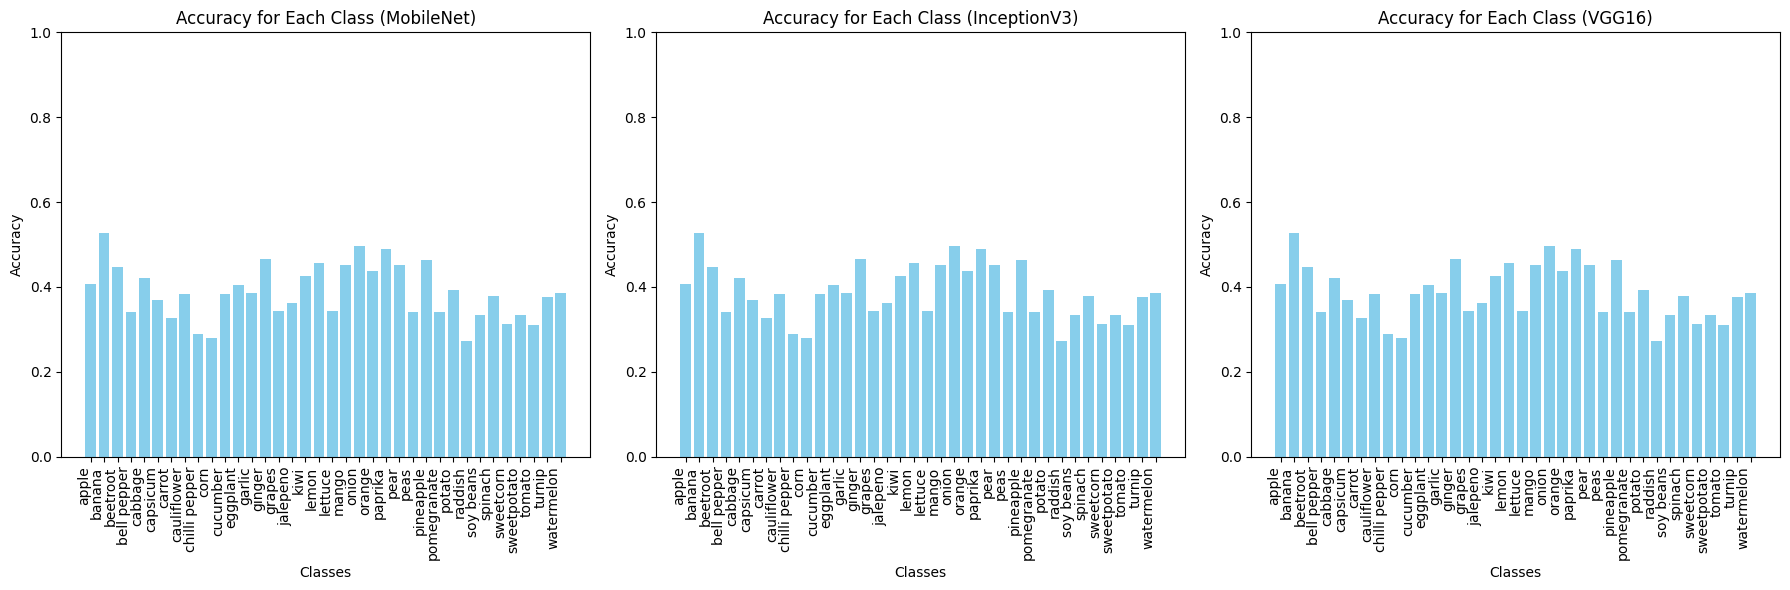

In [20]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.bar(avg_class_accuracy_mobilenet.keys(), avg_class_accuracy_mobilenet.values(), color='skyblue')
plt.title('Accuracy for Each Class (MobileNet)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
plt.bar(avg_class_accuracy_inception.keys(), avg_class_accuracy_inception.values(), color='skyblue')
plt.title('Accuracy for Each Class (InceptionV3)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
plt.bar(avg_class_accuracy_vgg16.keys(), avg_class_accuracy_vgg16.values(), color='skyblue')
plt.title('Accuracy for Each Class (VGG16)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


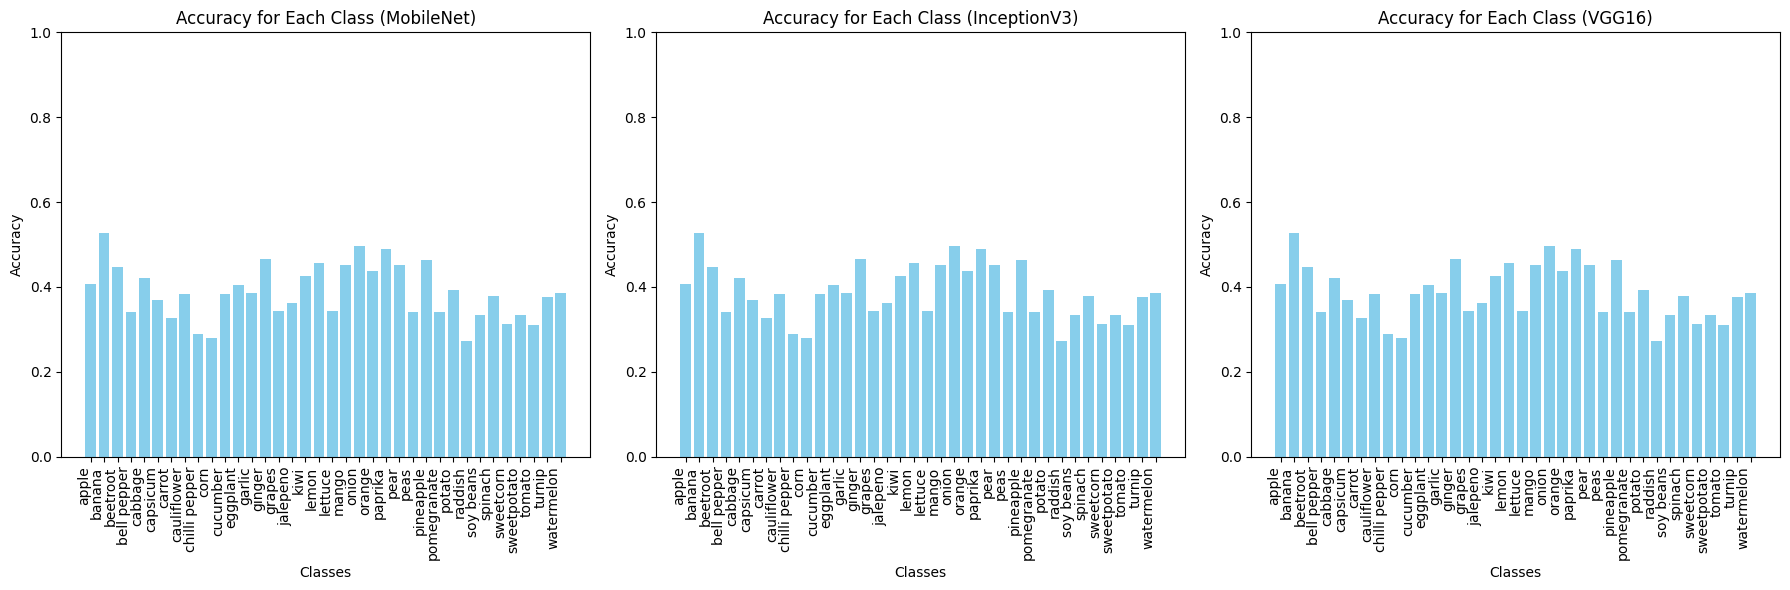

In [21]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.bar(avg_class_accuracy_mobilenet.keys(), avg_class_accuracy_mobilenet.values(), color='skyblue')
plt.title('Accuracy for Each Class (MobileNet)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
plt.bar(avg_class_accuracy_inception.keys(), avg_class_accuracy_inception.values(), color='skyblue')
plt.title('Accuracy for Each Class (InceptionV3)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
plt.bar(avg_class_accuracy_vgg16.keys(), avg_class_accuracy_vgg16.values(), color='skyblue')
plt.title('Accuracy for Each Class (VGG16)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


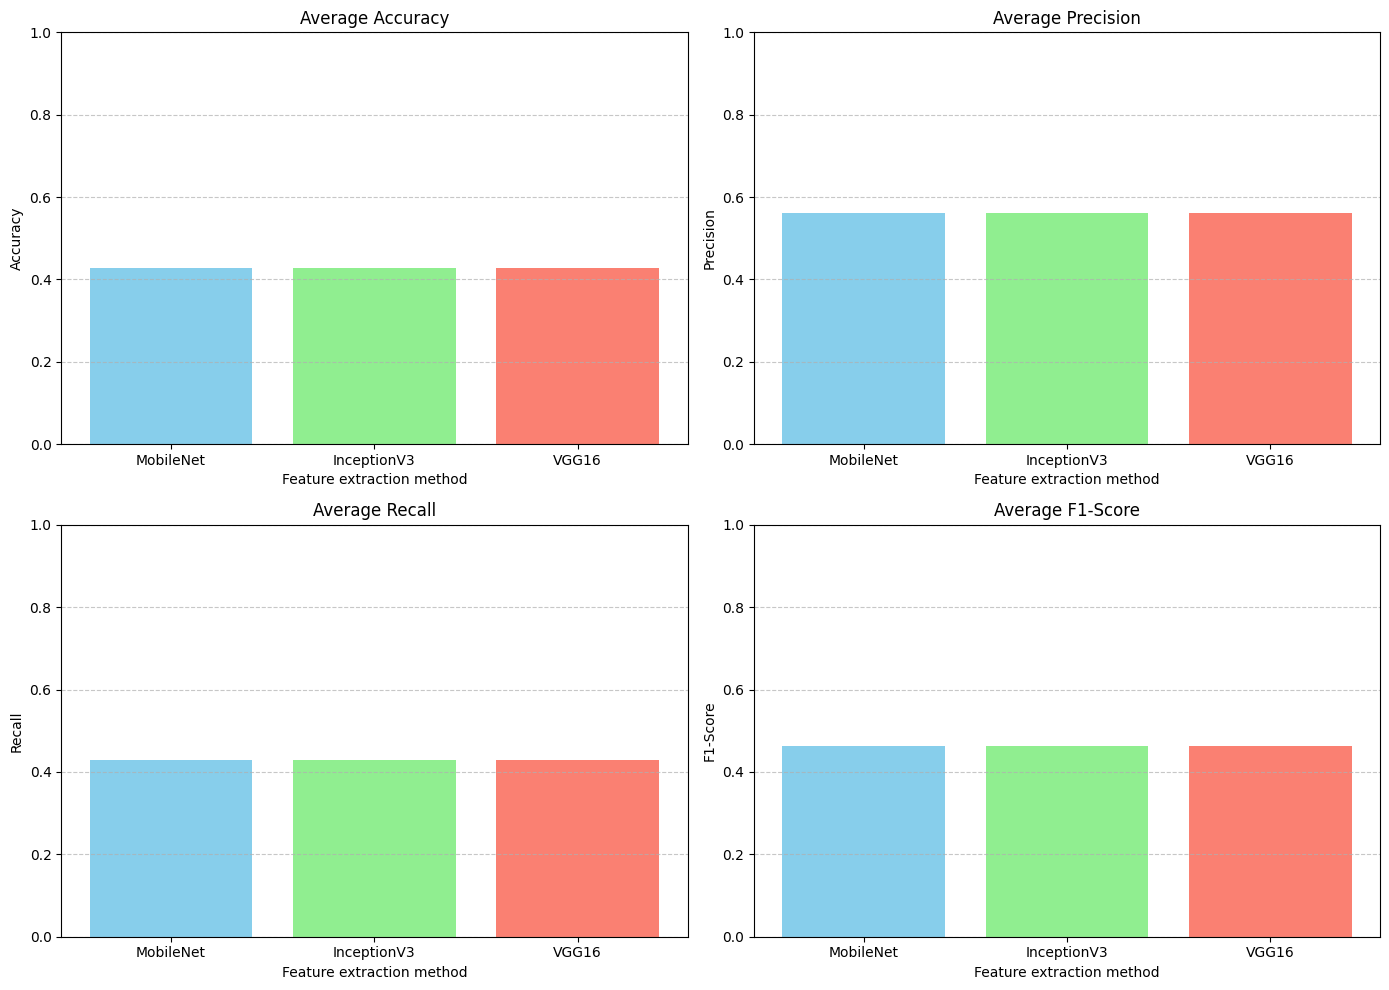

In [26]:
import numpy as np
import matplotlib.pyplot as plt

avg_scores = []
for model_scores in scores:
    avg_accuracy = np.mean([fold[0] for fold in model_scores])
    avg_precision = np.mean([fold[1] for fold in model_scores])
    avg_recall = np.mean([fold[2] for fold in model_scores])
    avg_f1 = np.mean([fold[3] for fold in model_scores])
    avg_scores.append((avg_accuracy, avg_precision, avg_recall, avg_f1))

accuracies, precisions, recalls, f1_scores = zip(*avg_scores)

methods = ['MobileNet', 'InceptionV3', 'VGG16']

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.bar(methods, avg_accuracy, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Accuracy')
plt.xlabel('Feature extraction method')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 2)
plt.bar(methods, avg_precision, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Precision')
plt.xlabel('Feature extraction method')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 3)
plt.bar(methods, avg_recall, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Recall')
plt.xlabel('Feature extraction method')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 4)
plt.bar(methods, avg_f1, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average F1-Score')
plt.xlabel('Feature extraction method')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [23]:
def corrected_t_test(accuracies_1, accuracies_2, corr=0.1):
    """
    Performs the corrected t-test for cross-validation results.

    Parameters:
    accuracies_1 (list or np.array): A list or array of accuracy scores from cross-validation for technique 1.
    accuracies_2 (list or np.array): A list or array of accuracy scores from cross-validation for technique 2.
    corr (float, optional): The correlation between successive folds.

    Returns:
    float: The t-statistic value.
    float: The p-value corresponding to the t-statistic.
    """
    m1 = len(accuracies_1)
    m2 = len(accuracies_2)
    mean_accuracy_1 = np.mean(accuracies_1)
    mean_accuracy_2 = np.mean(accuracies_2)
    variance_1 = np.var(accuracies_1, ddof=1)
    variance_2 = np.var(accuracies_2, ddof=1)
  
    
    corrected_variance_1 = variance_1 / (m1 * (1 - corr))
    corrected_variance_2 = variance_2 / (m2 * (1 - corr))
    standard_error = np.sqrt(corrected_variance_1 / m1 + corrected_variance_2 / m2)
    
    t_statistic = (mean_accuracy_1 - mean_accuracy_2) / standard_error
    p_value = stats.t.sf(np.abs(t_statistic), df=min(m1, m2) - 1) * 2  # two-tailed p-value
    
    return t_statistic, p_value

In [24]:

pairs = combinations([(avg_scores[0], 'MobileNet'), (avg_scores[1], 'InceptionV3'), (avg_scores[2], 'VGG16')], 2)

for pair in pairs:
    (technique_1, name_1), (technique_2, name_2) = pair
    
    t_statistic, p_value = corrected_t_test(technique_1, technique_2)
    
    if t_statistic > 0:
        comparison = f"{name_1} is better than {name_2}"
    elif t_statistic < 0:
        comparison = f"{name_2} is better than {name_1}"
    else:
        comparison = f"There is no significant difference between {name_1} and {name_2}"
    
    significance = "significant" if p_value < 0.05 else "not significant"
    
    print(f'{name_1} vs. {name_2}:')
    print(f'T-statistic: {t_statistic}')
    print(f'P-value: {p_value}')
    print(f'Result: {comparison} (p-value {significance})')


MobileNet vs. InceptionV3:
T-statistic: 0.6689548617527893
P-value: 0.5513994560154941
Result: MobileNet is better than InceptionV3 (p-value not significant)
MobileNet vs. VGG16:
T-statistic: 0.01762180251564406
P-value: 0.9870470152596826
Result: MobileNet is better than VGG16 (p-value not significant)
InceptionV3 vs. VGG16:
T-statistic: -0.6442577824250546
P-value: 0.5652785019494632
Result: VGG16 is better than InceptionV3 (p-value not significant)


/var/folders/kb/21stffp561n7vlhn9h_r55zc0000gn/T/ipykernel_66408/2718589805.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1)


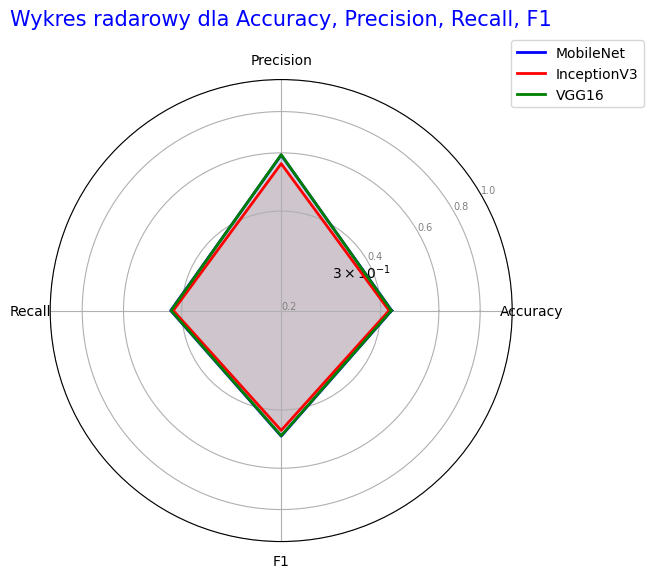

In [25]:

def create_radar_chart(df):
    categories = ['Accuracy', 'Precision', 'Recall', 'F1']
    N = len(categories)

    # Kąt dla każdej osi w wykresie radarowym
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Inicjalizacja wykresu
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Kolory dla każdego eksperymentu
    colors = ['b', 'r', 'g']
    
    for i, (model_name, experiment) in enumerate(df):
        values = experiment
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name, color=colors[i])
        ax.fill(angles, values, colors[i], alpha=0.1)
    
    # Dodanie etykiet osi
    plt.xticks(angles[:-1], categories)
    
    # Ustawienia osi y
    ax.set_rscale('log')
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=7)
    plt.ylim(0, 1)
    
    plt.title('Wykres radarowy dla Accuracy, Precision, Recall, F1', size=15, color='blue', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

models = [('MobileNet', avg_scores[0]), ('InceptionV3', avg_scores[1]), ('VGG16', avg_scores[2])]
create_radar_chart(models)
